## Feature engineering with pre-processed games

In [108]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from Scripts.mklib import code_toggle


In [2]:
%%time
with open('./../../../sc2games/PickledGames/iem_replays.p','rb') as corpus:
    iem_games = pickle.load(corpus)

CPU times: user 1.13 s, sys: 128 ms, total: 1.26 s
Wall time: 1.27 s


In [4]:
class Replay(object):
    def __init__(self, replay_dict, keep_source = False):
        
        if keep_source == True:
            self.source = replay_dict
        
        self.context = replay_dict['context'] 
        
        df_units = pd.DataFrame(data = replay_dict['objects']).T
        df_units.columns = columns=replay_dict['object_keys']
        
        df_units['x'], df_units['y'] = zip(*df_units['location'].values)
        df_units = df_units.drop(['location'], axis=1)
        
        df_stats = pd.DataFrame(data = replay_dict['player_stats'])
        df_stats.columns = columns=replay_dict['player_stat_keys']

        
        df_positions = pd.DataFrame([
            {**pos_dict['positions'],
             **{'frame':pos_dict['frame'], 'second':pos_dict['second']}} 
         for pos_dict in replay_dict['unit_positions']])
        
        df_positions.sort_values(by = 'frame', inplace = True)
        df_positions.fillna(method='ffill', inplace = True)
        
        unit_ids = sorted([col for col in df_positions.columns if type(col) == int])
        column_order = ['frame','second'] + unit_ids
        
        df_positions = df_positions[column_order]
        df_positions.reset_index(inplace = True, drop = True)
        
        df_upgrades = pd.DataFrame(replay_dict['upgrades'])\
        .applymap(lambda x: None if type(x) == str and 'SprayTerran' in x else x)\
        .dropna()

        df_outcome = pd.DataFrame([{'result':player['result'],'pid':player['pid']} 
                                   for player in replay_dict['context']['players']])
        
        self.units = df_units.sort_values(by = 'finished_at')
        self.stats = df_stats.sort_values(by = 'frame')
        self.positions = df_positions.sort_values(by = 'frame')
        self.upgrades = df_upgrades.sort_values(by = 'frame')
        self.outcome = df_outcome
        
        self.neat_outcome = [{str(player['pid'])+'_'+'result':player['result']}
                              for player in iem_games[0]['context']['players']]
        
    def unit_plotter(self, i):
        plt.scatter(*zip(*[v for v in self.positions.loc[i].values[2:] if v == v]))
        plt.show()
        
    def get_units_end(self):
        df = self.units
        df = df[df['died_at'].apply(lambda x:isinstance(x,type(None))).values]
        df = df[df['race']!= 'Neutral']
        
        x = df[['owner','race','name']]\
        .apply(lambda x: str(x['owner'])+x['race'][0]+'_'+ x['name'], axis=1)\
        .value_counts()
        return x
    
    def get_stats_end(self):
        df = self.stats.tail(3)
        
        p1 = df[df['pid']==1].tail(1).to_dict()
        p2 = df[df['pid']==2].tail().to_dict()

        p1 = {'1'+'_'+key:list(p1[key].values())[0] for key in p1.keys()}
        p2 = {'2'+'_'+key:list(p2[key].values())[0] for key in p2.keys()}

        return pd.Series({**p1,**p2})
    
    def get_outcome(self):
        return pd.Series({**self.neat_outcome[0], **self.neat_outcome[1]})
    
    def get_end_state(self):
        return pd.concat([self.get_units_end(), 
                          self.get_stats_end(), 
                          self.get_outcome()])

In [20]:
def get_end_location_of_units(game):
    try:
        runits = game.units
    except:
        runits = Replay(game).units
        
    runits = runits[(runits['died_at'].apply(lambda x:isinstance(x,type(None)))) 
                    & (runits['race'] != 'Neutral')][['name','x','y','owner']]
    return runits

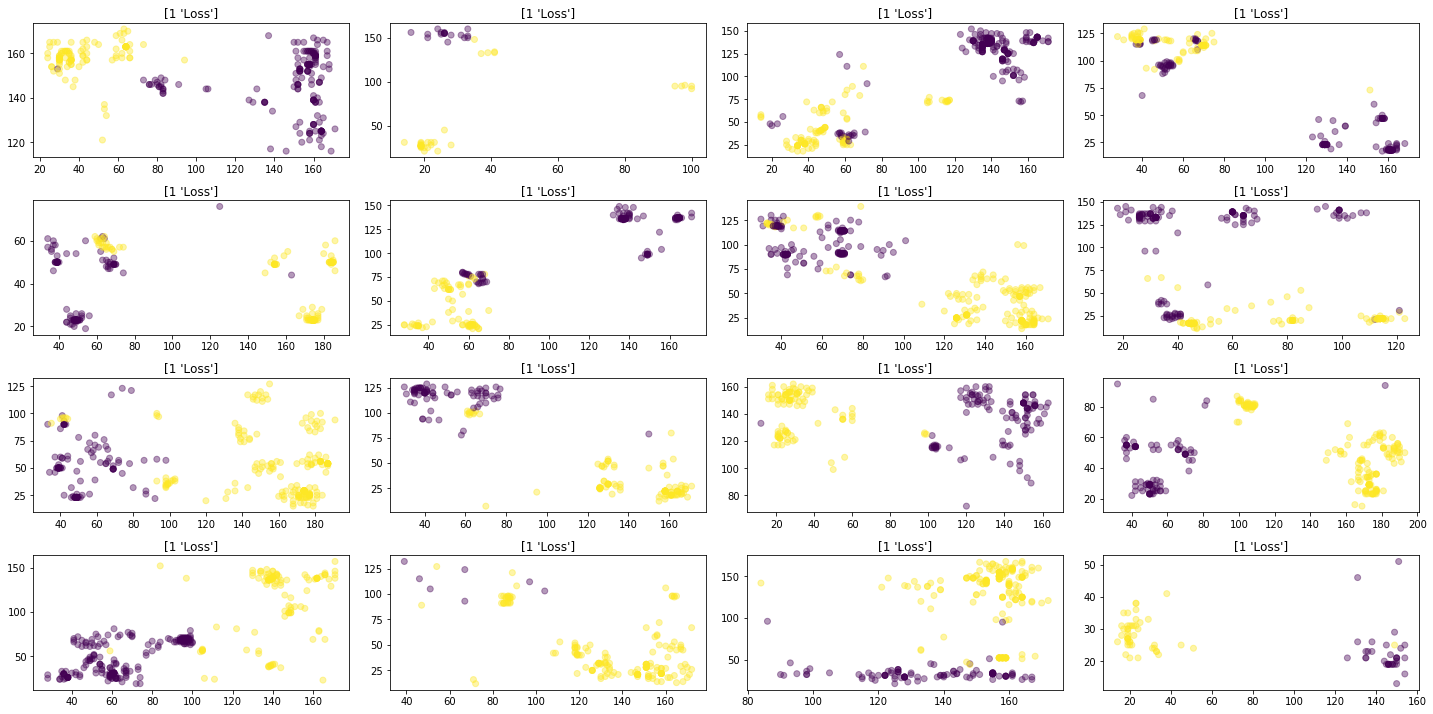

In [21]:
plt.figure(figsize=(20,10))
for i,game in enumerate(iem_games[0:16]):
    plt.subplot(4,4, i+1)
    runits = get_end_location_of_units(game)
    plt.scatter(runits['x'], runits['y'], c=runits['owner'], alpha = 0.4)
    plt.title(r.outcome.iloc[0].values)
plt.tight_layout(pad=1)
plt.show()

### Using clustering to quantify "being overrun" by looking at homogeneity.

In [71]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, homogeneity_completeness_v_measure

homogeneity_completeness_v_measure

# The terran marine has a range of 5.
# Tanks a range of between 7 and 13.
# Tempests have the longest range in the game at 15.

# We call a cluster any group of 5 or more units within a 10 tile radius.

unit_clusterer = DBSCAN(eps=10,min_samples=5)

runits = get_end_location_of_units(iem_games[6])
predicted_clusters = unit_clusterer.fit_predict(runits[['x','y']])

pid = 1
print(homogeneity_completeness_v_measure(runits['owner'][runits['owner']==pid], predicted_clusters[runits['owner']==pid]))
pid = 2
print(homogeneity_completeness_v_measure(runits['owner'][runits['owner']==pid], predicted_clusters[runits['owner']==pid]))

(1.0, 3.975706216432837e-16, 7.9514124328656701e-16)
(1.0, -2.5677375565841644e-16, -5.1354751131683297e-16)


In [75]:
for i in pd.Series(predicted_clusters).unique():
    print(homogeneity_completeness_v_measure(runits['owner'][predicted_clusters==i], 
                                             predicted_clusters[predicted_clusters==i]))

(0.0, 1.0, 0.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(0.0, 1.0, 0.0)
(-3.1036830574337008e-15, 1.0, -6.2073661148674205e-15)
(1.0, 1.0, 1.0)
(-1.7442235851550395e-16, 1.0, -3.48844717031008e-16)


In [80]:
i = 0
print(homogeneity_completeness_v_measure(runits['owner'][predicted_clusters==i].values, 
                                             predicted_clusters[predicted_clusters==i]))

(0.0, 1.0, 0.0)


In [89]:
(runits['owner'][predicted_clusters==i].value_counts())

1    37
2    12
Name: owner, dtype: int64

In [90]:
12/37

0.32432432432432434

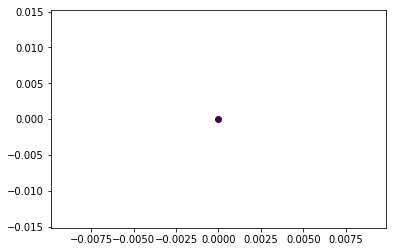

In [93]:
plt.scatter(x = [0], y = [0], c = 0)
plt.show()

In [82]:
predicted_clusters[predicted_clusters==i]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [76]:
pd.Series(predicted_clusters).unique()

array([ 0,  1,  2,  3,  4,  5, -1])

In [95]:
runits.iloc[predicted_clusters == 0]

,name,x,y,owner
51380225,Hive,38,122,1
52428801,Drone,35,125,1
53477377,Drone,37,125,1
54525953,Drone,39,125,1
59244545,Probe,43,125,2
61865985,Drone,38,119,1
63438849,Extractor,41,129,1
62914562,Drone,38,119,1
62128130,SpawningPool,35,130,1
74186754,Overlord,38,119,1


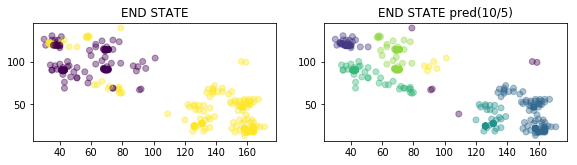

In [74]:
plt.figure(figsize=(20,10))
plt.subplot(4,4,1)
plt.scatter(runits['x'], runits['y'], c=runits['owner'], alpha = 0.4)
plt.title('END STATE')

plt.subplot(4,4,2)
plt.scatter(runits['x'], runits['y'], c=predicted_clusters, alpha = 0.4)
plt.title('END STATE pred(10/5)')

plt.show()

In [100]:
pd.DataFrame({'t':runits['owner'],'p':predicted_clusters}).head()

,p,t
51380225,0,1
52428801,0,1
53477377,0,1
54525953,0,1
55836673,1,2


In [65]:
runits['owner'].dtype

dtype('O')

In [28]:
A = [1,1,1,1,1,1,1] + [2,2,2,2,2,2,2]
B = [1,1,1,0,0,0,1] + [3,,3,3,3,3,3]
homogeneity_completeness_v_measure(A,B)

(0.76820625015453314, 0.4934975364007031, 0.60094595251068039)

In [ ]:
pd.DataFrame(confusion_matrix(runits['owner'].astype(int)*-1 + 3,y), columns=[-1,1,2])

In [ ]:
import numpy as np
plt.cm.Accent
import itertools

In [ ]:
plot_confusion_matrix(confusion_matrix(runits['owner'].astype(int)-1,y), classes=['outlier','p1','p2'])

In [ ]:
silhouette_score(runits[['x','y']], runits['owner'])

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [99]:
r = Replay(iem_games[0])
r.units.sample(5)
r.stats.sample(5)
r.positions.sample(5)
r.upgrades.sample(5)
r.outcome

,pid,result
0,1,Win
1,2,Loss


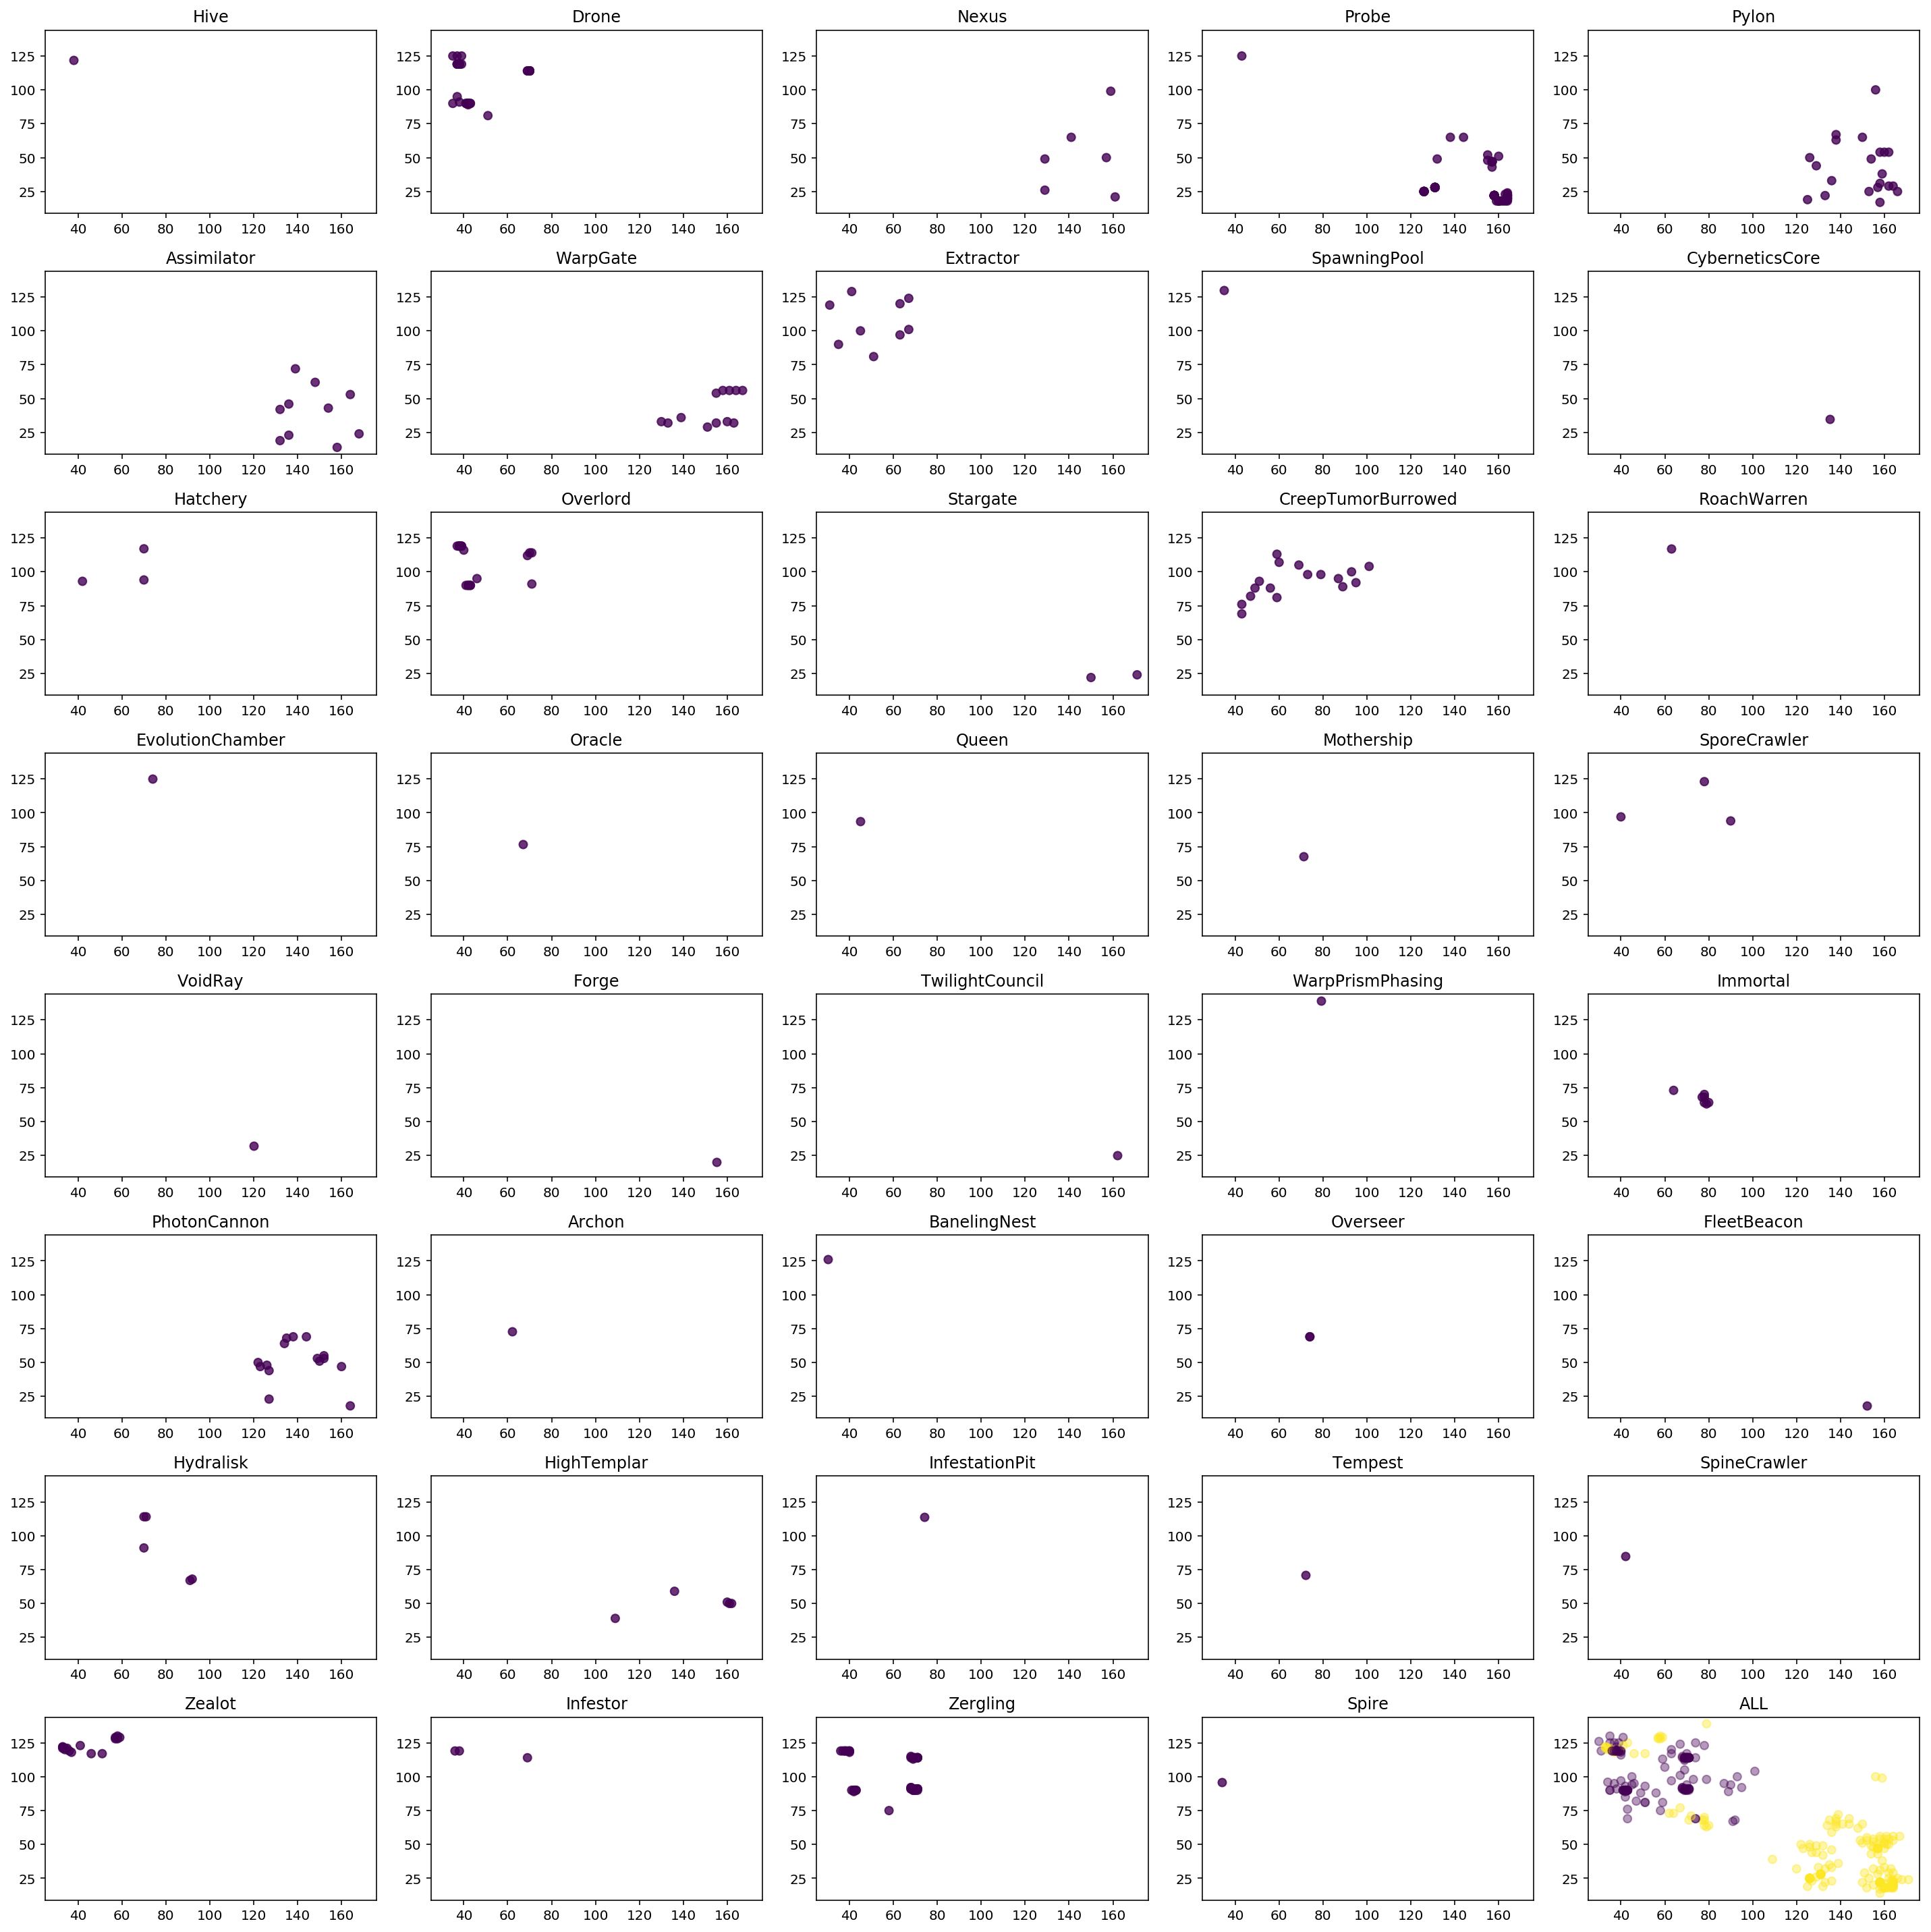

In [107]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(20,20))

xmin, xmax = runits['x'].min(),runits['x'].max()
ymin, ymax = runits['y'].min(),runits['y'].max()

for i,name in enumerate(list(runits['name'].unique())+['ALL']):
    plt.subplot(8,5, i+1)
    al = 0.8
    _runits = runits[(runits['name'] == name)]
    if name == 'ALL': 
        _runits = runits
        al = 0.4
    _ = plt.scatter(_runits['x'], _runits['y'], c=_runits['owner'], alpha = al)
    plt.title(name)
    plt.xlim(xmin-5, xmax+5)
    plt.ylim(ymin-5, ymax+5)
    
plt.tight_layout(h_pad=1)
plt.show()

In [ ]:
runits.name.unique()

In [ ]:
plt.figure(figsize=(20,10))
for i,names in enumerate([
    ['OrbitalCommand','SCV','SupplyDepotLowered','Refinery',
     'Barracks','Factory','Starport','SupplyDepot','EngineeringBay','MissileTurret',
     'SensorTower','Armory','CommandCenter'], 
    ['Marine','SiegeTank','Medivac','Viking']]):
    plt.subplot(4,5, i+1)
    al = 0.8
    print(names)
    _runits = runits[runits['name'].apply(lambda x:x in names)]
    _ = plt.scatter(_runits['x'], _runits['y'], c=_runits['owner'], alpha = al)
    
    plt.title(['Economy','Army'][i])
    plt.xlim(17,175)
    plt.ylim(110,175)
    
plt.tight_layout(h_pad=1)
plt.show()

In [10]:
r.units

,died_at,finished_at,hallucinated,id,killed_by,killed_units,killing_player,killing_unit,name,owner,race,started_at,x,y
1,None,0,False,1,None,[],None,None,MineralField,-1,Neutral,0,122,90
54263809,None,0,False,54263809,None,[],None,None,MineralField,-1,Neutral,0,60,79
54001665,None,0,False,54001665,None,[],None,None,MineralField750,-1,Neutral,0,61,80
53739521,None,0,False,53739521,None,[],None,None,MineralField,-1,Neutral,0,60,81
53477377,None,0,False,53477377,None,[],None,None,MineralField750,-1,Neutral,0,60,83
53215233,None,0,False,53215233,None,[],None,None,MineralField750,-1,Neutral,0,90,57
52953089,None,0,False,52953089,None,[],None,None,MineralField,-1,Neutral,0,91,58
52690945,None,0,False,52690945,None,[],None,None,MineralField750,-1,Neutral,0,92,59
52428801,None,0,False,52428801,None,[],None,None,MineralField750,-1,Neutral,0,95,60
52166657,None,0,False,52166657,None,[],None,None,MineralField,-1,Neutral,0,96,59


In [17]:
type(iem_games)

list

In [19]:
r = Replay(iem_games[0])

In [20]:
r

In [25]:
r.upgrades

,frame,pid,second,upgrade_type_name
3,9466,2,591,Stimpack
6,10061,1,628,Stimpack
1,10277,2,642,ShieldWall
22,10479,2,654,TerranInfantryWeaponsLevel1
16,11307,1,706,TerranInfantryWeaponsLevel1
18,11310,1,706,TerranInfantryArmorsLevel1
20,12624,1,789,ShieldWall
27,13068,2,816,TerranInfantryArmorsLevel1
24,14697,1,918,TerranVehicleWeaponsLevel1
9,14796,1,924,TerranInfantryWeaponsLevel2


In [26]:
pd.DataFrame(iem_games)

,context,object_keys,objects,player_stat_keys,player_stats,unit_positions,upgrades
0,"{'region': 'xx', 'map_name': 'Cactus Valley LE...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[17280, 2351, 388, 1000, 0, 0, 1, 985, 589, 2...","[{'positions': {22544386: (87, 155), 78381085:...","[{'upgrade_type_name': 'SprayTerran', 'frame':..."
1,"{'region': 'xx', 'map_name': 'Honorgrounds LE'...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[3840, 923, 60, 200, 450, 150, 1, 291, 68, 0,...","[{'positions': {85721091: (31, 150), 88080385:...","[{'upgrade_type_name': 'SprayTerran', 'frame':..."
2,"{'region': 'xx', 'map_name': 'Proxima Station ...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[3200, 1035, 45, 0, 625, 200, 2, 156, 48, 0, ...","[{'positions': {70778881: (144, 102), 73400321...",[{'upgrade_type_name': 'TerranInfantryArmorsLe...
3,"{'region': 'xx', 'map_name': 'Abyssal Reef LE'...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[960, 755, 155, 0, 150, 0, 2, 0, 0, 0, 0, 0],...","[{'positions': {67108877: (49, 87), 69992451: ...","[{'upgrade_type_name': 'GlialReconstitution', ..."
4,"{'region': 'xx', 'map_name': 'Newkirk Precinct...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[1120, 811, 275, 0, 0, 0, 1, 0, 0, 0, 0, 0], ...","[{'positions': {67108865: (181, 54), 78381057:...","[{'upgrade_type_name': 'SprayZerg', 'frame': 5..."
5,"{'region': 'xx', 'map_name': 'Proxima Station ...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[6720, 783, 85, 0, 100, 0, 2, 0, 0, 0, 0, 0],...","[{'positions': {58458113: (58, 23), 61341704: ...","[{'upgrade_type_name': 'SprayZerg', 'frame': 1..."
6,"{'region': 'xx', 'map_name': 'Abyssal Reef LE'...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[3680, 895, 90, 100, 100, 150, 2, 335, 58, 25...","[{'positions': {9437193: (58, 84), 66584581: (...",[{'upgrade_type_name': 'ProtossGroundWeaponsLe...
7,"{'region': 'xx', 'map_name': 'Bel'Shir Vestige...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[3200, 923, 120, 350, 100, 0, 2, 44, 12, 0, 0...","[{'positions': {54001665: (51, 95), 55836677: ...","[{'upgrade_type_name': 'SprayZerg', 'frame': 1..."
8,"{'region': 'xx', 'map_name': 'Newkirk Precinct...","[died_at, finished_at, hallucinated, id, kille...","{1: [None, 0, False, 1, None, [], None, None, ...","[frame, minerals_collection_rate, minerals_cur...","[[1120, 811, 260, 0, 0, 0, 1, 0, 0, 0, 0, 0], ...","[{'positions': {28835845: (77, 111), 55574542:...","[{'upgrade_type_name': 'NeuralParasite', 'fram..."
9,"{'region': 'xx', 'map_name': 'Abyssal Reef LE'...","[died_at, finished_at, hallucinated, id, kille...","{1: [13926, 0, False, 1, 1, [], 1, None, (37, ...","[frame, minerals_collection_rate, minerals_cur...","[[11200, 1651, 510, 450, 400, 0, 1, 671, 150, ...","[{'positions': {72351745: (152, 49), 77594625:...","[{'upgrade_type_name': 'SprayProtoss', 'frame'..."


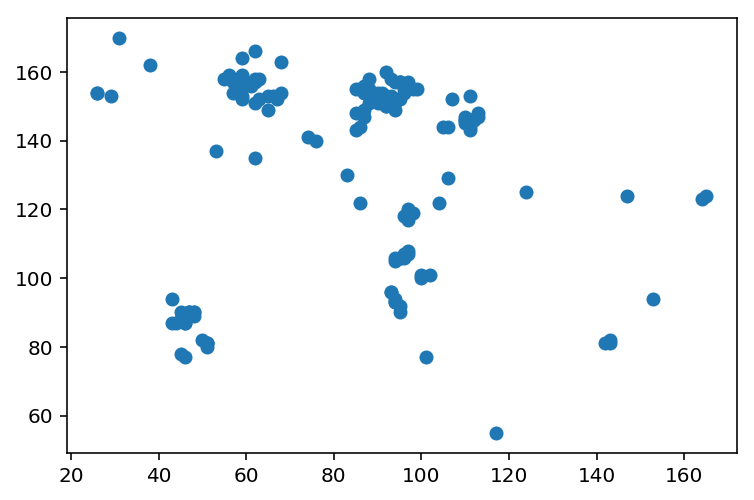

In [30]:
Replay(iem_games[0]).unit_plotter(30)


In [ ]:
r.